In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import tensorflow as tf
import urllib2

%matplotlib inline

# From https://gist.github.com/kylemcdonald/2f1b9a255993bf9b2629
def showarray(a, fmt='png'):
    import IPython.display
    from cStringIO import StringIO
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [2]:
sess = tf.InteractiveSession()

In [33]:
# 1. RGB -> YCbCr
# https://en.wikipedia.org/wiki/YCbCr
def rgb_to_ycbcr(image):
    matrix = np.array([[65.481, 128.553, 24.966],
                       [-37.797, -74.203, 112.],
                       [112., -93.786, -18.214]], dtype=np.float32).T / 255
    shift = [16., 128., 128.]
    
    result = tf.tensordot(image, matrix, axes=1) + shift
    result.set_shape(image.shape.as_list())
    return result

def rgb_to_ycbcr_jpeg(image):
    matrix = np.array([[0.299, 0.587, 0.114],
                       [-0.168736, -0.331264, 0.5],
                       [0.5, -0.418688, -0.081312]], dtype=np.float32).T
    shift = [0., 128., 128.]
    
    result = tf.tensordot(image, matrix, axes=1) + shift
    result.set_shape(image.shape.as_list())
    return result

In [4]:
# 2. Chroma subsampling
def downsampling_420(image):
    # input: batch x height x width x 3
    # output: tuple of length 3
    #   y:  batch x height x width
    #   cb: batch x height/2 x width/2
    #   cr: batch x height/2 x width/2
    y, cb, cr = tf.split(image, 3, axis=3)
    cb = tf.nn.avg_pool(cb, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    cr = tf.nn.avg_pool(cr, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.squeeze(y, axis=-1), tf.squeeze(cb, axis=-1), tf.squeeze(cr, axis=-1)

In [5]:
# 3. Block splitting
# From https://stackoverflow.com/questions/41564321/split-image-tensor-into-small-patches
def image_to_patches(image):
    # input: batch x h x w
    # output: batch x h*w/64 x h x w
    k = 8
    batch_size, height, width = image.shape.as_list()[0:3]
    image_reshaped = tf.reshape(image, [batch_size, height // k, k, -1, k])
    image_transposed = tf.transpose(image_reshaped, [0, 1, 3, 2, 4])
    return tf.reshape(image_transposed, [batch_size, -1, k, k])

In [6]:
# 4. DCT
def dct_8x8_ref(image):
    image = image - 128
    result = np.zeros((8, 8), dtype=np.float32)
    for u, v in itertools.product(range(8), range(8)):
        value = 0
        for x, y in itertools.product(range(8), range(8)):
            value += image[x, y] * np.cos((2*x+1)*u*np.pi/16) * np.cos((2*y+1)*v*np.pi/16)
        result[u, v] = value
    alpha = np.array([1./np.sqrt(2)] + [1] * 7)
    scale = np.outer(alpha, alpha) * 0.25
    return result * scale

def dct_8x8(image):
    image = image - 128
    tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
    for x, y, u, v in itertools.product(range(8), repeat=4):
        tensor[x, y, u, v] = np.cos((2*x+1)*u*np.pi/16) * np.cos((2*y+1)*v*np.pi/16)
    alpha = np.array([1./np.sqrt(2)] + [1] * 7)
    scale = np.outer(alpha, alpha) * 0.25
    result = scale * tf.tensordot(image, tensor, axes=2)
    result.set_shape(image.shape.as_list())
    return result

In [7]:
# 5. Quantizaztion
y_table = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]], dtype=np.float32).T
c_table = np.empty((8, 8), dtype=np.float32)
c_table.fill(99)
c_table[:4, :4] = np.array([[17, 18, 24, 47],
                            [18, 21, 26, 66],
                            [24, 26, 56, 99],
                            [47, 66, 99, 99]]).T

def y_quantize(image, rounding, factor=1):
    image = image / (y_table * factor)
    image = rounding(image)
    return image
def c_quantize(image, rounding, factor=1):
    image = image / (c_table * factor)
    image = rounding(image)
    return image

# -5. Dequantization
def y_dequantize(image, factor=1):
    return image * (y_table * factor)
def c_dequantize(image, factor=1):
    return image * (c_table * factor)

In [8]:
# -4. Inverse DCT
def idct_8x8_ref(image):
    alpha = np.array([1./np.sqrt(2)] + [1] * 7)
    alpha = np.outer(alpha, alpha)
    image = image * alpha

    result = np.zeros((8, 8), dtype=np.float32)
    for u, v in itertools.product(range(8), range(8)):
        value = 0
        for x, y in itertools.product(range(8), range(8)):
            value += image[x, y] * np.cos((2*u+1)*x*np.pi/16) * np.cos((2*v+1)*y*np.pi/16)
        result[u, v] = value
    return result * 0.25 + 128

def idct_8x8(image):
    alpha = np.array([1./np.sqrt(2)] + [1] * 7)
    alpha = np.outer(alpha, alpha)
    image = image * alpha
    
    tensor = np.zeros((8, 8, 8, 8), dtype=np.float32)
    for x, y, u, v in itertools.product(range(8), repeat=4):
        tensor[x, y, u, v] = np.cos((2*u+1)*x*np.pi/16) * np.cos((2*v+1)*y*np.pi/16)
    result = 0.25 * tf.tensordot(image, tensor, axes=2) + 128
    result.set_shape(image.shape.as_list())
    return result


In [9]:
# -3. Block joining
def patches_to_image(patches, height, width):
    # input: batch x h*w/64 x h x w
    # output: batch x h x w
    k = 8
    batch_size = patches.shape.as_list()[0]
    image_reshaped = tf.reshape(patches, [batch_size, height // k, width // k, k, k])
    image_transposed = tf.transpose(image_reshaped, [0, 1, 3, 2, 4])
    return tf.reshape(image_transposed, [batch_size, height, width])

In [10]:
# -2. Chroma upsampling
def upsampling_420(y, cb, cr):
    # input:
    #   y:  batch x height x width
    #   cb: batch x height/2 x width/2
    #   cr: batch x height/2 x width/2
    # output:
    #   image: batch x height x width x 3
    def repeat(x, k=2):
        height, width = x.shape.as_list()[1:3]
        x = tf.expand_dims(x, -1)
        x = tf.tile(x, [1, 1, k, k])
        x = tf.reshape(x, [-1, height * k, width * k])
        return x
    cb = repeat(cb)
    cr = repeat(cr)
    return tf.stack((y, cb, cr), axis=-1)

In [11]:
# -1. YCbCr -> RGB
def ycbcr_to_rgb(image):
    matrix = np.array([[298.082, 0, 408.583],
                       [298.082, -100.291, -208.120],
                       [298.082, 516.412, 0]], dtype=np.float32).T / 256
    shift = [-222.921, 135.576, -276.836]
    
    result = tf.tensordot(image, matrix, axes=1) + shift
    result.set_shape(image.shape.as_list())
    return result

def ycbcr_to_rgb_jpeg(image):
    matrix = np.array([[1., 0., 1.402],
                       [1, -0.344136, -0.714136],
                       [1, 1.772, 0]], dtype=np.float32).T
    shift = [0, -128, -128]
    
    result = tf.tensordot(image + shift, matrix, axes=1)
    result.set_shape(image.shape.as_list())
    return result

In [70]:
def jpeg_compress_decompress(image, downsample_c=True, rounding=tf.round, factor=1):
    image = tf.convert_to_tensor(image)
    height, width = image.shape.as_list()[1:3]
    orig_height, orig_width = height, width
    if height % 16 != 0 or width % 16 != 0:
        # Round up to next multiple of 16
        height = ((height - 1) // 16 + 1) * 16
        width = ((width - 1) // 16 + 1) * 16

        vpad = height - orig_height
        wpad = width - orig_width
        top = vpad // 2
        bottom = vpad - top
        left = wpad // 2
        right = wpad - left
        
        image = tf.pad(image, [[0, 0], [top, bottom], [left, right], [0, 0]], 'SYMMETRIC')
    
    # "Compression"
    image = rgb_to_ycbcr_jpeg(image)
    if downsample_c:
        y, cb, cr = downsampling_420(image)
    else:
        y, cb, cr = tf.split(image, 3, axis=3)
    components = {'y': y, 'cb': cb, 'cr': cr}
    for k in components.keys():
        comp = components[k]
        comp = image_to_patches(comp)
        comp = dct_8x8(comp)
        comp = c_quantize(comp, rounding, factor) if k in ('cb', 'cr') else y_quantize(comp, rounding, factor)
        components[k] = comp
    
    # "Decompression"
    for k in components.keys():
        comp = components[k]
        comp = c_dequantize(comp, factor) if k in ('cb', 'cr') else y_dequantize(comp, factor)
        comp = idct_8x8(comp)
        if k in ('cb', 'cr'):
            if downsample_c:
                comp = patches_to_image(comp, height / 2, width / 2)
            else:
                comp = patches_to_image(comp, height, width)
        else: 
            comp = patches_to_image(comp, height, width)
        components[k] = comp
    
    y, cb, cr = components['y'], components['cb'], components['cr']
    if downsample_c:
        image = upsampling_420(y, cb, cr)
    else:
        image = tf.stack((y, cb, cr), axis=-1)
    image = ycbcr_to_rgb_jpeg(image)

    # Crop to original size
    if orig_height != height or orig_width != width:
        image = image[:, top:-bottom, left:-right]

    # Hack: RGB -> YUV -> RGB sometimes results in incorrect values
#    min_value = tf.minimum(tf.reduce_min(image), 0.)
#    max_value = tf.maximum(tf.reduce_max(image), 255.)
#    value_range = max_value - min_value
#    image = 255 * (image - min_value) / value_range
    image = tf.minimum(255., tf.maximum(0., image))
    
    return image

In [71]:
# Testing
fabio_url = 'https://juliaimages.github.io/TestImages.jl/images/fabio_color_256.png'
lena_url = 'https://juliaimages.github.io/TestImages.jl/images/lena_color_256.tif'
fabio = np.array(PIL.Image.open(
    urllib2.urlopen(fabio_url)).resize((299, 299), resample=PIL.Image.BICUBIC), dtype=np.float32)
lena = np.array(PIL.Image.open(
    urllib2.urlopen(lena_url)).resize((299, 299), resample=PIL.Image.BICUBIC), dtype=np.float32)

In [110]:
# Factor: (0, infty)
# Greater factors: more compression
compressed_tf = jpeg_compress_decompress(np.stack([fabio, lena]), factor=2)
fabio_c, lena_c = compressed_tf.eval()

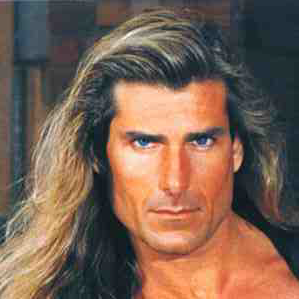

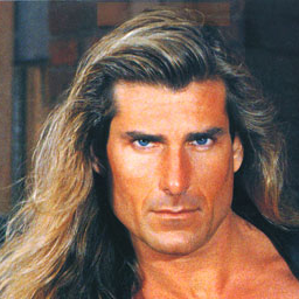

In [111]:
showarray(fabio_c)
showarray(fabio)

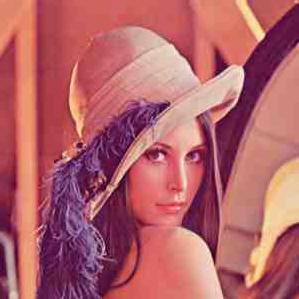

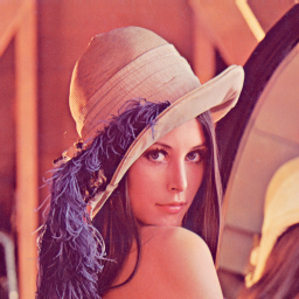

In [112]:
showarray(lena_c)
showarray(lena)

In [75]:
lena_c.shape

(299, 299, 3)

In [113]:
# Use diff_round instead of tf.round
def diff_round(x):
    return tf.round(x) + (x - tf.round(x))**3
def round_only_at_0(x):
    cond = tf.cast(tf.abs(x) < 0.5, tf.float32)
    return cond * (x ** 3) + (1 - cond) * x
compressed_tf = jpeg_compress_decompress(np.stack([fabio, lena]), rounding=round_only_at_0, factor=3)
fabio_c, lena_c = compressed_tf.eval()

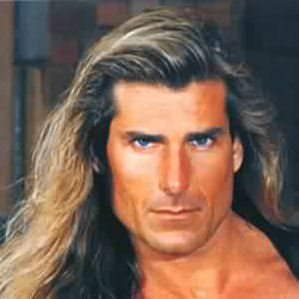

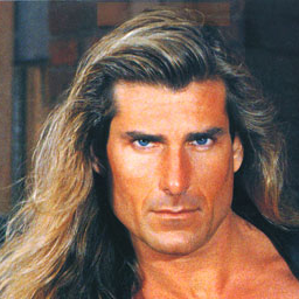

In [114]:
showarray(fabio_c)
showarray(fabio)

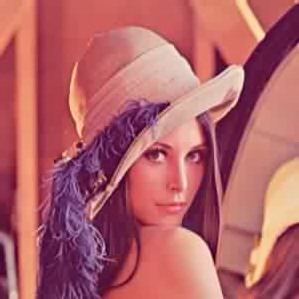

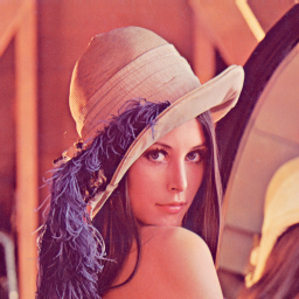

In [115]:
showarray(lena_c)
showarray(lena)

In [85]:
# Computing gradients
# tf.round needs to be replaced with a differentiable function for this to work.
image_ph = tf.placeholder(dtype=tf.float32, shape=(2, 256, 256, 3))
compressed_ph = jpeg_compress_decompress(image_ph, rounding=round_only_at_0)
tf.gradients(tf.reduce_sum(compressed_ph), [image_ph])

[<tf.Tensor 'gradients_2/Tensordot_131/transpose_grad/transpose:0' shape=(2, 256, 256, 3) dtype=float32>]

In [22]:
x = tf.placeholder(tf.float32)
grad_x = tf.gradients(diff_round(x), [x])[0]
grad_x.eval({x: [0, 0.01, 0.49, 0.5, 0.51, 0.99, 1]})

array([  0.00000000e+00,   2.99999985e-04,   7.20300019e-01,
         7.50000000e-01,   7.20300019e-01,   2.99999432e-04,
         0.00000000e+00], dtype=float32)

In [23]:
sample = np.array([[52, 55, 61, 66, 70, 61, 64, 73],
                   [63, 59, 55, 90, 109, 85, 69, 72],
                   [62, 59, 68, 113, 144, 104, 66, 73],
                   [63, 58, 71, 122, 154, 106, 70, 69],
                   [67, 61, 68, 104, 126, 88, 68, 70],
                   [79, 65, 60, 70, 77, 68, 58, 75],
                   [85, 71, 64, 59, 55, 61, 65, 83],
                   [87, 79, 69, 68, 65, 76, 78, 94]], dtype=np.float32).T
print dct_8x8_ref(sample)
print idct_8x8_ref(dct_8x8_ref(sample))

print dct_8x8(tf.constant(sample)).eval()
print idct_8x8(dct_8x8(tf.constant(sample))).eval()

[[ -4.15375000e+02   4.46552367e+00  -4.68344844e+01  -4.85349674e+01
    1.21249996e+01  -7.73474378e+00  -1.03067404e+00  -1.65375604e-01]
 [ -3.01857186e+01  -2.18574390e+01   7.37059736e+00   1.20683613e+01
   -6.55345011e+00   2.90546131e+00   1.83067441e-01   1.41607121e-01]
 [ -6.11970622e+01  -6.07580376e+01   7.71293869e+01   3.40997658e+01
   -1.31961212e+01   2.37979579e+00   4.16815460e-01  -1.07153642e+00]
 [  2.72393234e+01   1.02536364e+01  -2.45619831e+01  -1.47594109e+01
   -3.95142770e+00  -5.93931389e+00  -2.41556144e+00  -4.19291210e+00]
 [  5.61249985e+01   1.31451101e+01  -2.89116879e+01  -1.02406073e+01
   -1.87500000e+00  -2.37779665e+00  -8.77793908e-01  -1.17031407e+00]
 [ -2.00951736e+01  -7.08741808e+00   9.93352127e+00   6.29596758e+00
    1.74528444e+00   9.41391587e-01  -3.01930666e+00  -9.77610797e-02]
 [ -2.38764712e+00  -8.53543663e+00   5.41681528e+00   1.83116508e+00
   -2.78722835e+00   4.30371332e+00   4.12061262e+00   5.01269400e-01]
 [  4.6181545

In [91]:
def quality_to_factor(quality):
    if quality < 50:
        quality = 5000. / quality
    else:
        quality = 200. - quality*2
    return quality / 100.


In [103]:
quality_to_factor(1)

50.0